In [1]:
%matplotlib inline
import matplotlib
import seaborn as sns
sns.set()
matplotlib.rcParams['figure.dpi'] = 144

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from pylib.draw_nn import draw_neural_net_fig

tf.debugging.set_log_device_placement(True)

In [3]:
## THIS OPTION ALLOWS TF TO GROW VRAM ON THE GPU
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   try:
#     # Currently, memory growth needs to be the same across GPUs
#     for gpu in gpus:
#       tf.config.experimental.set_memory_growth(gpu, True)
#     logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#   except RuntimeError as e:
#     # Memory growth must be set before GPUs have been initialized
#     print(e)


## THIS OPTION CONFIGURES THE VRAM AVAILABLE FOR TF UP-FRONT
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 4GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


<!-- requirement: pylib/__init__.py -->
<!-- requirement: pylib/draw_nn.py -->
<!-- requirement: pylib/tf_utils.py -->
<!-- requirement: pylib/mnist_dataset.py -->
<!-- requirement: images/neuron.svg -->

# Basic Neural Networks


The operation of a logistic regression model is not so dissimilar from a neuron.  A neuron has many dendrites, each of which gets some input.  These inputs are individually weighted and all of the inputs are summed by the soma.  Depending on the result, the neuron may send a signal out its axon, to trigger other neurons.

![neuron](images/neuron.svg)
<!-- Copyright Quasar Jarosz.  Distributed under the CC Attribution-Share Alike 3.0 Unported Licence.  https://commons.wikimedia.org/wiki/File:Neuron_Hand-tuned.svg -->

Similarly, a logistic regression takes many inputs, weights each, and combines them into a single output.  We can think of this model as an **artificial neuron**. We'll first examine the logistic regression model in detail and then begin extending separate logistic regressors into basic neural networks.

(Note: This analogy should not be taken too seriously&mdash;real neurons fire a discrete pulse every time the potential in the soma exceeds a threshold, while our model outputs a continuous value depending on the current value of all its inputs.  Nonetheless, there is enough similarity to think that wiring together artificial neurons could improve their performance, in the same way that an entire brain performs better than a single neuron.)

## The XOR problem


Research into artificial neurons dates to the late 40s, but it was not until 1969 that Marvin Minsky and Seymour Papert pointed out that basic neurons were unable to reproduce the **exclusive-or** (XOR) function.  This Boolean function of two Boolean variables returns true if exactly one of its inputs is true:

$$ \mathrm{XOR}(0, 0) = \mathrm{XOR}(1, 1) = 0 \ \ \ \ \ \ \mathrm{XOR}(0, 1) = \mathrm{XOR}(1, 0) = 1 $$

Below, we create a related two-class classification problem, with one class clustered about (0, 0) and (1, 1), and the other about (0, 1) and (1, 0).  It would be quite easy to draw a boundary separating the two classes by hand. 

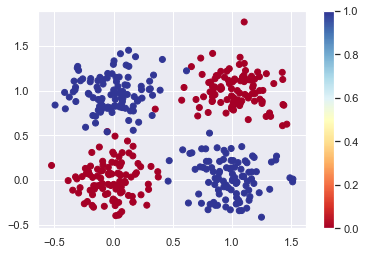

In [4]:
centers = np.array([[0, 0]] * 100 + [[1, 1]] * 100
                   + [[0, 1]] * 100 + [[1, 0]] * 100)
np.random.seed(42)
data = (np.random.normal(0, 0.2, (400, 2)) + centers).astype(np.float32)
labels = np.array([[0]] * 200 + [[1]] * 200).astype(np.float32)

plt.scatter(data[:,0], data[:,1], c=labels.ravel(), cmap=plt.cm.RdYlBu)
plt.colorbar();

## Logistic Regression

As described in the [TF_Intro_TensorFlow notebook](TF_Intro_TensorFlow.ipynb), this is a **classification** problem (particularly **binary classification**, in which labels are positive, 1, or negative, 0). Thus far we've been dealing with regression: the task of predicting quantitative labels. When labels are categorical, we'll need to use different metrics for training and evaluating our model.

One approach to classification problems is to develop a function that returns the probability of an observation belong to the target class.  We can use this, along with a threshold probability, to actually predict the class.  (By default the threshold would be $\bar p = 0.5$, but this could be adjusted to reflect the relative importance of false positives and false negatives.)

We could use a linear model as a probability estimate.  But the linear model will give us numbers less than 0 and greater than 1, which are meaningless as probabilities.  The usual solution is to send the output of the linear model into the **logistic** (or **sigmoid**) function:

$$ f(x) = \frac{1}{1 + e^{-x}} $$

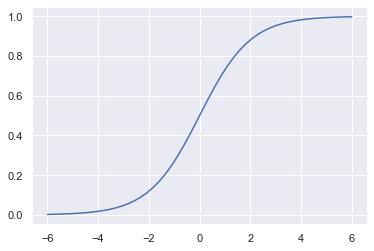

In [5]:
lx = np.linspace(-6,6)
plt.plot(lx, 1 / (1 + np.exp(-lx)));

### Cross Entropy


While we could use mean squared error to evaluate a probabilistic model, it doesn't quite capture our intuition about probability.  Suppose we have an observation with label 0.  One model predicts a $p=0.9$ while a second predicts $p = 0.99$.  The former should happen one time in ten, while the latter only once in a hundred.  But the squared errors are comparable (0.81 vs 0.9801).

A metric that better captures this nature is the **cross entropy**, or **log-loss**:

$$ L = -\frac{1}{n}\sum_{j=1}^{n} y_j \log p_j + (1 - y_j) \log (1-p_j) $$

This is not as complicated as it may appear.  Because the labels $y_j \in \{0, 1\}$, only one term contributes from each summand.  If $y_j = 1$, the summand becomes simply $\log p_j$, the log of the probability we put on it being in class 1.  If $y_j = 0$, we get just $\log (1-p_j)$, which is the log of probability we put on it being in class 0.  As this probability approaches zero, the log becomes deeply negative, so the entropy becomes large.

> **Aside:** There is a deep connection between the cross-entropy metric and information theory.  In this case, the entropy is measuring the average number of bits per observation we'd need to specify the classes correctly, given an optimal encoding.

Although the formula for the entropy is more complicated than the mean squared error, TensorFlow can easily use the chain rule to calculate the necessary gradients.  It's even easier than you might think, because TensorFlow provides both the logistic function (as `tf.nn.sigmoid()`) and a entropy calculated from logistic values (as `tf.nn.sigmoid_cross_entropy_with_logits()`).

Most of the setup is the same as for linear regression, but we'll use the new loss function.

In [6]:
class LogisticRegression():
    def __init__(self, eta=.1):
        self.opt = tf.keras.optimizers.SGD(learning_rate=eta)
    
    def loss(self, X, y, return_func=False):
        def loss_():
            logits = tf.matmul(X, self.W) + self.b
            return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=y))
        
        if not return_func:
            return loss_()
        
        return loss_
    
    def fit(self, X, y, steps=10):
        if not hasattr(self, 'W'):
            self.W = tf.Variable(np.zeros((X.shape[1], 1), dtype=X.dtype))
        if not hasattr(self, 'b'):
            self.b = tf.Variable(np.zeros((1, 1), dtype=X.dtype))
        
        for _ in range(steps):
            self.opt.minimize(self.loss(X, y, return_func=True), [self.W, self.b])
            
        return self
    
    def predict_proba(self, X):
        return tf.nn.sigmoid(tf.matmul(X, self.W) + self.b)
        
    def predict(self, X):
        return tf.cast(self.predict_proba(X) > 0.5, tf.float32)
    
    def score(self, X, y):
        return tf.reduce_mean(tf.cast(tf.equal(self.predict(X), y), tf.float64))

While the entropy is good for the purposes of a loss function, it is a bit hard to interpret.  A more human-readable metric is the **accuracy**, which measures what fraction of the labels we predicted correctly.

Here, we make a prediction by calling the logistic function on our linear model, and then comparing that to a threshold of 0.5.  The accuracy is measured by figuring if the predictions are equal to the ground truth labels, casting the result to a float, and taking the average.

In [7]:
model = LogisticRegression(eta=.5)

for i in range(10):
    model.fit(data, labels, 30)
    print('Loss: {}'.format(model.loss(data, labels)))
    print('Accuracy: {}'.format(model.score(data, labels)))

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op MatMul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ZerosLike in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GreaterEqual in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Select in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Neg in device /job:localhost/replic

That's a bit odd.  The model seems to get stuck on 52% accuracy.  More notably, the entropy has barely improved at all.

Let's visualize the predictions.  Note that the color scale only covers a portion of the range.

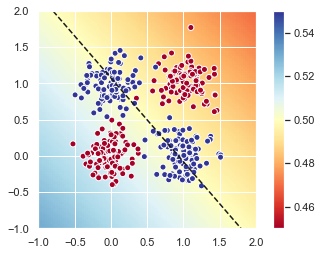

In [8]:
mesh = np.column_stack([a.reshape(-1) for a in np.meshgrid(np.r_[-1:2:100j], np.r_[-1:2:100j])]).astype(np.float32)
ymesh = model.predict_proba(mesh).numpy()
ww, bb = model.W.numpy(), model.b.numpy()

plt.imshow(ymesh.reshape(100,100), cmap=plt.cm.RdYlBu, origin='lower',
           extent=(-1, 2, -1, 2), vmin=0.45, vmax=0.55)
plt.colorbar()
plt.scatter(data[:, 0], data[:, 1], c=labels.ravel(), cmap=plt.cm.RdYlBu,
            edgecolor='w', lw=1)
xx = np.linspace(-1, 2, 100)
yy = (-ww[0] / ww[1] * xx - bb / ww[1]).squeeze()
plt.plot(xx, yy, 'k--')
plt.axis((-1, 2, -1, 2));

Now the problem becomes apparent: The model is returning nearly a 50% probability for each observation.  Therefore the entropy is stuck at just about $-\log\frac12 \approx 0.6931$.

We can draw a line at $p = 0.5$ to separate the two classes.  From the logistic function, we know this is equivalent to $x\cdot W + b = 0$.  Thus, our model is attempting to draw a straight line through the plane to separate the two classes.  (In the general case, logistic regression separates the classes with a $(n-1)$-D hyperplane in $n$-D space.)  No line can do that in this case, so the model falls back to guessing 50% for each.

We might wonder why the line wasn't chosen to separate one cluster from the other three.  This could have given us an accuracy approaching 0.75.  But remember that we are optimizing entropy, which is based on the probability estimates, not accuracy.  Because the probability grows the further we go from the threshold line, the penalty for the one cluster on the wrong side of the line would outweigh the gains from the two clusters put fully on the right side.


### Exercise: Multi-class classification

The extension of the logistic function to multi-class classification is called [the softmax function](https://en.wikipedia.org/wiki/Softmax_function). The cross-entropy can then be modified for multiple classes.

$$ L = -\frac{1}{n}\sum_{j=1}^{n} \sum_{k=1}^C y_k^{(j)} \log p_k^{(j)} $$

Here $y_k^{(j)}$ is an indicator variable which is one if the $j^{th}$ observation is in class $k$, and zero otherwise.  This method of encoding categorical information is known as **one-hot encoding**.

For this exercise, we're going to switch data sets and use the famous [MNIST database](https://en.wikipedia.org/wiki/MNIST_database) of handwritten digits.  Each example is a $28\times28$ pixel grayscale image.  We'll read them in along with one-hot encoded labels.

In [9]:
from pylib import tf_utils

x_train, y_train = tf_utils.mnist_train()
x_test, y_test = tf_utils.mnist_test()

y_train = tf.one_hot(y_train, 10).numpy()
y_test = tf.one_hot(y_test, 10).numpy()

Executing op Reshape in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op BatchDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Iter

The images come in as 1-D vectors.  We need to reshape them to view the images. 

Label: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


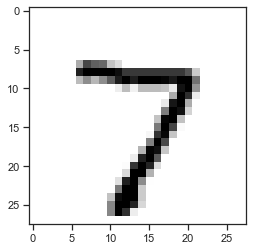

In [10]:
with sns.axes_style("ticks"):
    plt.imshow(x_test[0].reshape((28, 28)),
               cmap=plt.cm.gray_r, interpolation='nearest')
print("Label:", y_test[0])

Modify the logistic regression so that it now has an output of dimension 10, instead of 1. [TensorFlow has a built-in softmax entropy function for us to use](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/nn/softmax_cross_entropy_with_logits).  Note that the softmax is monotonic, so we don't need to calculate the probabilities to tell which class we're predicting.  We can just find the largest component of the result of our linear model.

As a bonus, try visualizing the weights associated with each class as an image!

In [11]:
class SoftmaxClassifier():
    def __init__(self, eta=.1):
        self.opt = tf.keras.optimizers.SGD(learning_rate=eta)
    
    def loss(self, X, y, return_func=False):
        def loss_():
            logits = tf.matmul(X, self.W) + self.b
            return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
        
        if not return_func:
            return loss_()
        
        return loss_
    
    def fit(self, X, y, steps=10):
        if not hasattr(self, 'W'):
            self.W = tf.Variable(np.zeros((X.shape[1], y.shape[1]), dtype=X.dtype))
        if not hasattr(self, 'b'):
            self.b = tf.Variable(np.zeros((1, y.shape[1]), dtype=X.dtype))
        
        for _ in range(steps):
            self.opt.minimize(self.loss(X, y, return_func=True), [self.W, self.b])
            
        return self
    
    def predict_proba(self, X):
        return tf.nn.softmax(tf.matmul(X, self.W) + self.b)
        
    def predict(self, X):
        return tf.cast(tf.argmax(self.predict_proba(X), axis=1), tf.float32)
    
    def score(self, X, y):
        return tf.reduce_mean(tf.cast(tf.equal(self.predict(X),
                                               tf.cast(tf.argmax(y, axis=1), tf.float32)), tf.float64))

In [12]:
model = SoftmaxClassifier(eta=.5)

for i in range(10):
    model.fit(x_train, y_train, 30)
    print('Loss: {}'.format(model.loss(x_test, y_test)))
    print('Accuracy: {}'.format(model.score(x_test, y_test)))

Executing op DestroyResourceOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Pack in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Slice in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ConcatV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op SoftmaxCrossEntropyWithLogits in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ExpandDims in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogSoftmax in device /job:localhost/replica:0/task:0/device:GPU:0
Loss: 0.5049237608909607
Executing op Softmax in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ArgMax in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in devic

Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0


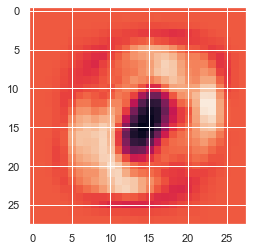

In [13]:
# visualizing model weights for class 0
plt.imshow(model.W[:, 0].numpy().reshape((28, 28)))

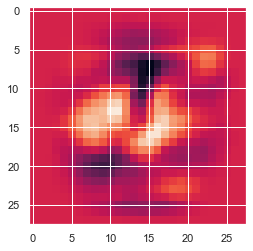

In [14]:
# visualizing model weights for class 4
plt.imshow(model.W[:, 4].numpy().reshape((28, 28)))

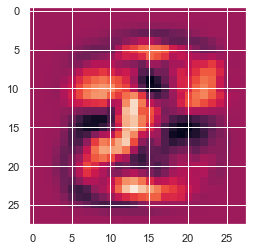

In [15]:
# visualizing model weights for class 8
plt.imshow(model.W[:, 8].numpy().reshape((28, 28)))

## Neural networks and hidden layers


Our logistic regressor accepts two inputs and yields a single output.

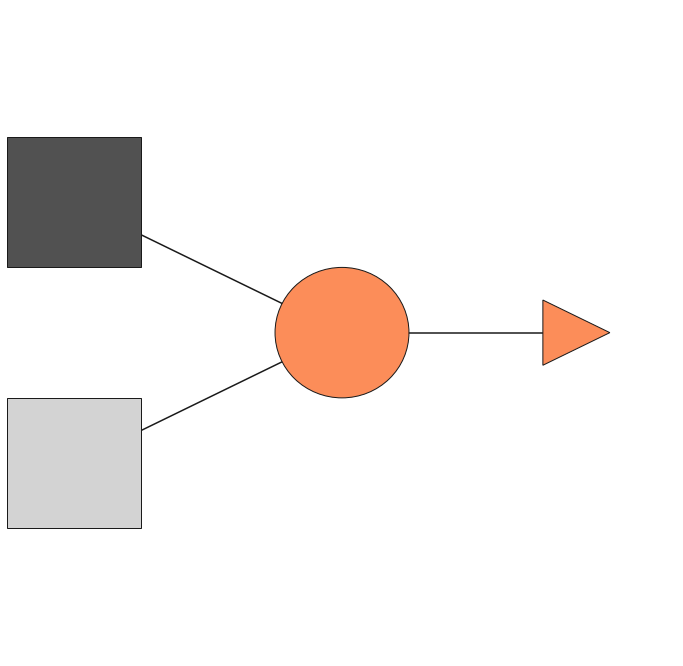

In [16]:
draw_neural_net_fig([2, 1])

If we take the view that this logistic regressor represents a neuron, we could imagine combining multiple artificial neurons into a more complex configuration.  We'll make a network with a single **hidden layer** of size two.  That is, we will have two logistic regressions whose outputs are not visible.  Instead, they are fed into a third, visible neuron, whose output we use.

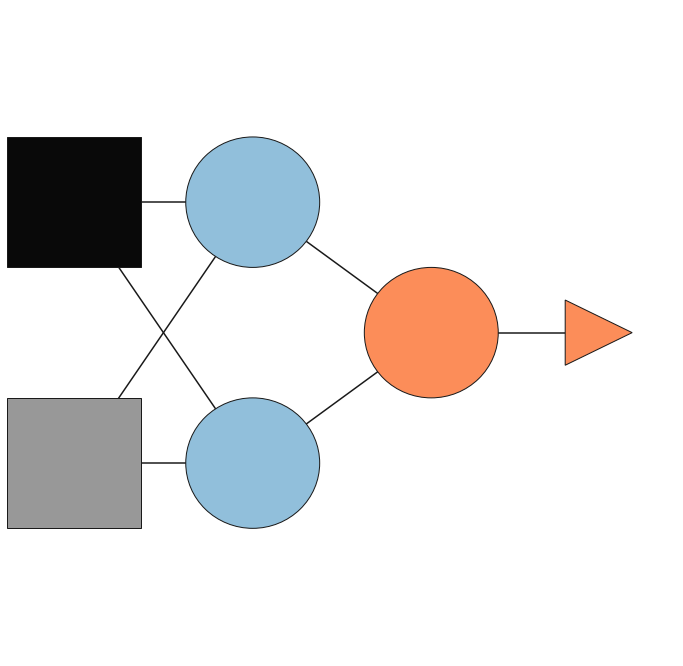

In [17]:
draw_neural_net_fig([2, 2, 1])

The math behind this isn't as bad as it might seem at first.  All of the weights of the neurons in the hidden layer can be combined into a single $2\times2$ matrix $W^{(1)}$.  The final neuron's weights will be in a $2\times1$ matrix $W^{(2)}$.  The biases behave similarly.  Then our final probabilistic prediction is just

$$ p_j = f_2\bigg( f_1\left( X_{ji} W^{(1)}_{ik} + b^{(1)}_k \right) W^{(2)}_k + b^{(2)} \bigg).$$

We are using the Einstein notation: All repeated indices are implicitly summed over.  Both $f_1$ and $f_2$ represent the logistic function, which is taken to operate element-wise over tensors.

The **backpropagation** algorithm, developed by Paul Werbos in 1975, points out that we can use gradient descent (or similar algorithms) to optimize all of the parameters in these sorts of expressions.  All it takes is successive applications of the chain rule.  In fact, there's nothing special we have to do to make use of it: TensorFlow's optimizers automatically work though the successive derivatives to generate the update rules.  All we have to do is set up the calculation:

In [18]:
class DenseNeuralNetwork():
    def __init__(self, layer_shapes, eta=.1):
        self.layer_shapes = layer_shapes
        self.opt = tf.keras.optimizers.SGD(learning_rate=eta)
    
    def loss(self, X, y, return_func=False):        
        def loss_():
            W, b = self.layers[0]
            h = tf.nn.sigmoid(tf.matmul(X, W) + b)

            for W, b in self.layers[1:-1]:
                h = tf.nn.sigmoid(tf.matmul(h, W) + b)
        
            W, b = self.layers[-1]
            logits = tf.matmul(h, W) + b
            return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=y))
        
        if not return_func:
            return loss_()
        
        return loss_
    
    def fit(self, X, y, steps=10):
        if not hasattr(self, 'layers'):
            self.layers = [(
                tf.Variable(tf.random.normal(shape)),
                tf.Variable(tf.zeros(shape[1]))
            ) for shape in self.layer_shapes]
            
        for _ in range(steps):
            self.opt.minimize(self.loss(X, y, return_func=True), [var for layer in self.layers for var in layer])
            
        return self
    
    def predict_proba(self, X):
        W, b = self.layers[0]
        h = tf.nn.sigmoid(tf.matmul(X, W) + b)

        for W, b in self.layers[1:-1]:
            h = tf.nn.sigmoid(tf.matmul(h, W) + b)
        
        W, b = self.layers[-1]
        return tf.nn.sigmoid(tf.matmul(h, W) + b)
        
    def predict(self, X):
        return tf.cast(self.predict_proba(X) > 0.5, dtype=tf.float32)
    
    def score(self, X, y):
        return tf.reduce_mean(tf.cast(tf.equal(self.predict(X), y), dtype=tf.float32))

In [19]:
hidden_size = 2

layers = [(2, hidden_size), (hidden_size, 1)]

dnn = DenseNeuralNetwork(layers, eta=.5)

for i in range(10):
    dnn.fit(data, labels, 300)
    print('Loss: {}'.format(dnn.loss(data, labels)))
    print('Accuracy: {}'.format(dnn.score(data, labels)))

Executing op RandomStandardNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op MatMul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op SigmoidGrad in device /job:localhost/replica:0/task:0/device:GPU:0
Loss: 0.6448134779930115
Accuracy: 0.7074999809265137
Loss: 0.5110618472099304
Accuracy: 0.7225000262260437
Loss: 0.24197296798229218
Accuracy: 0.9449999928474426
Loss: 0.16367818415164948
Accuracy: 0.9474999904632568
Loss: 0.1418781876564026
Accuracy: 0.9524999856948853
Loss: 0.13316704332828522
Accuracy: 0.9524999856948853
Loss: 0.12895552814006805
Accuracy: 0.949999988079071
Loss: 0.1266781985759735
Accuracy: 0.949999988079071
Loss: 0.1

And let's run it.  We need a few more steps to get all of the weights well-trained.

We can verify the improved accuracy by examining our predictions.

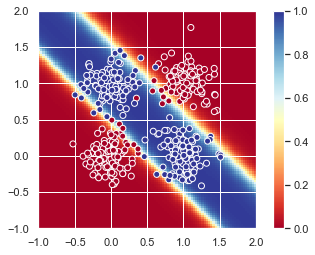

In [20]:
mesh = np.column_stack([a.reshape(-1) for a in np.meshgrid(np.r_[-1:2:100j], np.r_[-1:2:100j])]).astype(np.float32)
ymesh = dnn.predict_proba(mesh).numpy()

plt.imshow(ymesh.reshape(100,100), cmap=plt.cm.RdYlBu, origin='lower',
           extent=(-1, 2, -1, 2), vmin=0, vmax=1)
plt.scatter(data[:, 0], data[:, 1], c=labels.ravel(), cmap=plt.cm.RdYlBu,
            edgecolor='w', lw=1)
plt.axis((-1, 2, -1, 2))
plt.colorbar();

How is that stripe created?  We can get some understanding by looking at the weights of the hidden layer.

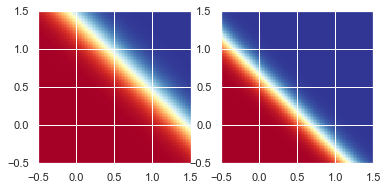

In [21]:
ww1 = dnn.layers[0][0].numpy()
hmesh = tf.nn.sigmoid(tf.matmul(mesh, dnn.layers[0][0]) + dnn.layers[0][1]).numpy()

for i in range(hidden_size):
    plt.subplot(1, hidden_size, i+1)
    plt.imshow(hmesh[:, i].reshape((100, 100)), origin='lower', cmap=plt.cm.RdYlBu,
               extent=(-0.5,1.5,-0.5,1.5))

Now we can see how each hidden neuron is just defining a line through the feature space.  Each line defines one side of the strip.

Note that the colors are inverted from the final probabilities.  We can understand what's going on by examining the weights in the second layer:

In [22]:
dnn.layers[1][0].numpy()

array([[-10.944192],
       [ 10.18377 ]], dtype=float32)

### Exercise: Number of hidden neurons


Change the number of neurons in the hidden layer.  How does this change the predictions made by the model?  What happens when you add many neurons to this hidden layer?


In [23]:
hidden_size = 4

layers = [(2, hidden_size), (hidden_size, 1)]

dnn = DenseNeuralNetwork(layers, eta=.5)

for i in range(10):
    dnn.fit(data, labels, 300)
    print('Loss: {}'.format(dnn.loss(data, labels)))
    print('Accuracy: {}'.format(dnn.score(data, labels)))

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Loss: 0.5615567564964294
Accuracy: 0.8550000190734863
Loss: 0.2240726351737976
Accuracy: 0.9574999809265137
Loss: 0.14140722155570984
Accuracy: 0.9599999785423279
Loss: 0.11236650496721268
Accuracy: 0.9674999713897705
Loss: 0.09649699181318283
Accuracy: 0.9674999713897705
Loss: 0.08578960597515106
Accuracy: 0.9700000286102295
Loss: 0.07783178240060806
Accuracy: 0.9725000262260437
Loss: 0.07167692482471466
Accuracy: 0.9750000238418579
Loss: 0.0668332651257515
Accuracy: 0.9750000238418579
Loss: 0.06297729909420013
Accuracy: 0.9750000238418579


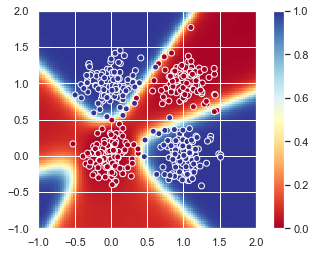

In [24]:
mesh = np.column_stack([a.reshape(-1) for a in np.meshgrid(np.r_[-1:2:100j], np.r_[-1:2:100j])]).astype(np.float32)
ymesh = dnn.predict_proba(mesh).numpy()

plt.imshow(ymesh.reshape(100,100), cmap=plt.cm.RdYlBu, origin='lower',
           extent=(-1, 2, -1, 2), vmin=0, vmax=1)
plt.scatter(data[:, 0], data[:, 1], c=labels.ravel(), cmap=plt.cm.RdYlBu,
            edgecolor='w', lw=1)
plt.axis((-1, 2, -1, 2))
plt.colorbar();

## Activation functions


How important is the logistic function in the hidden neurons?  We can easily take them out and see what happens.

In [25]:
class DenseNeuralNetwork():
    def __init__(self, layer_shapes, eta=.1):
        self.layer_shapes = layer_shapes
        self.opt = tf.keras.optimizers.SGD(learning_rate=eta)
    
    def loss(self, X, y, return_func=False):        
        def loss_():
            W, b = self.layers[0]
            h = tf.matmul(X, W) + b

            for W, b in self.layers[1:-1]:
                h = tf.matmul(h, W) + b
        
            W, b = self.layers[-1]
            logits = tf.matmul(h, W) + b
            return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=y))
        
        if not return_func:
            return loss_()
        
        return loss_
    
    def fit(self, X, y, steps=10):
        if not hasattr(self, 'layers'):
            self.layers = [(
                tf.Variable(tf.random.normal(shape)),
                tf.Variable(tf.zeros(shape[1]))
            ) for shape in self.layer_shapes]
            
        for _ in range(steps):
            self.opt.minimize(self.loss(X, y, return_func=True), [var for layer in self.layers for var in layer])
            
        return self
    
    def predict_proba(self, X):
        W, b = self.layers[0]
        h = tf.matmul(X, W) + b

        for W, b in self.layers[1:-1]:
            h = tf.matmul(h, W) + b
        
        W, b = self.layers[-1]
        return tf.nn.sigmoid(tf.matmul(h, W) + b)
        
    def predict(self, X):
        return tf.cast(self.predict_proba(X) > 0.5, dtype=tf.float32)
    
    def score(self, X, y):
        return tf.reduce_mean(tf.cast(tf.equal(self.predict(X), y), dtype=tf.float32))

In [26]:
hidden_size = 2

layers = [(2, hidden_size), (hidden_size, 1)]

dnn = DenseNeuralNetwork(layers, eta=.5)

for i in range(10):
    dnn.fit(data, labels, 300)
    print('Loss: {}'.format(dnn.loss(data, labels)))
    print('Accuracy: {}'.format(dnn.score(data, labels)))

Loss: 0.693023145198822
Accuracy: 0.5249999761581421
Loss: 0.693023145198822
Accuracy: 0.5249999761581421
Loss: 0.693023145198822
Accuracy: 0.5249999761581421
Loss: 0.693023145198822
Accuracy: 0.5249999761581421
Loss: 0.693023145198822
Accuracy: 0.5249999761581421
Loss: 0.693023145198822
Accuracy: 0.5249999761581421
Loss: 0.693023145198822
Accuracy: 0.5249999761581421
Loss: 0.693023145198822
Accuracy: 0.5249999761581421
Loss: 0.693023145198822
Accuracy: 0.5249999761581421
Loss: 0.693023145198822
Accuracy: 0.5249999761581421


That doesn't look good.  It seems that we've fallen back to the single neuron case again.

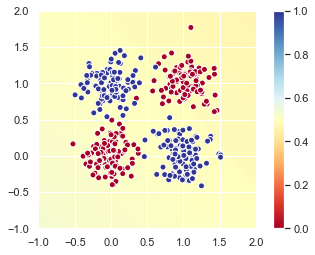

In [27]:
mesh = np.column_stack([a.reshape(-1) for a in np.meshgrid(np.r_[-1:2:100j], np.r_[-1:2:100j])]).astype(np.float32)
ymesh = dnn.predict_proba(mesh).numpy()

plt.imshow(ymesh.reshape(100,100), cmap=plt.cm.RdYlBu, origin='lower',
           extent=(-1, 2, -1, 2), vmin=0, vmax=1)
plt.scatter(data[:, 0], data[:, 1], c=labels.ravel(), cmap=plt.cm.RdYlBu,
            edgecolor='w', lw=1)
plt.axis((-1, 2, -1, 2))
plt.colorbar();

This behavior becomes obvious when we consider the full neural network function, with $f_1$ being the identity function:

$$ p_j = f_2\bigg( \left( X_{ji} W^{(1)}_{ik} + b^{(1)}_k \right) W^{(2)}_k + b^{(2)} \bigg) = f_2\bigg( X_{ji} \color{red}{W^{(1)}_{ik} W^{(2)}_k} + \color{blue}{b^{(1)}_k W^{(2)}_k + b^{(2)}} \bigg) $$

This is just logistic regression, with the <font color="red">weights</font> and <font color="blue">bias</font> written in a rather funny way.  Given this, it would be odd if we didn't see this behavior!

This function, $f_1$, is known as the **activation function** of the neuron.  As we just saw, the fact that the activation function is nonlinear is crucial.  This is what keeps the whole network from just being a linear transformation.  Any non-linearity will do though, so a number of different activation functions have been proposed.  Here are a few:

Executing op Sigmoid in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Tanh in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Relu in device /job:localhost/replica:0/task:0/device:GPU:0


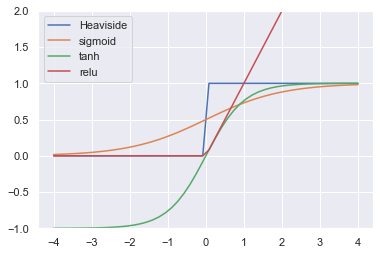

In [28]:
xx = np.linspace(-4, 4)
plt.plot(xx, xx > 0, label='Heaviside')
plt.plot(xx, tf.nn.sigmoid(xx), label='sigmoid')
plt.plot(xx, tf.nn.tanh(xx), label='tanh')
plt.plot(xx, tf.nn.relu(xx), label='relu')
plt.legend(loc=2)
plt.ylim(-1, 2);

The first perceptron, a single-layer neural network, designed by Frank Rosenblatt in 1957, used the **Heaviside** or **step** function.  This is essentially equivalent to using a threshold with logistic regression.  While this is fine for predicting a class, it has slope 0 almost everywhere, and therefore is unsuitable for use with gradient descent algorithms.

We have already seen the **sigmoid** function used in logistic regression.  In a sense, it smooths out the step function, allowing a usable gradient in the area near $x = 0$.  Because the function saturates at $\pm\infty$, the gradient goes to zero for large positive or negative inputs.  This can cause optimization algorithms to slow down.

The average output of a sigmoid is 0.5, but it performs best when the average input is 0.  Thus, several layers of sigmoid neurons may push themselves away from optimal behavior.  One solution to this is use a **tanh** instead.  While the general shape is the same, its range is [-1, 1], so the output will on average be 0.

The tanh will still have trouble with saturation of the signal.  Recently, many researchers have had success with the **rectified linear unit (ReLU)**: $f(x) = \max(0, x)$.  While it might seem to combine the problems of the other functions (non-analytic points, zero derivatives, non-centered output), in practice it tends to be quite successful.

ReLU neurons are susceptible to dying, however.  If they get into a state where the combined input is negative, both their output value and gradient become zero, and the neurons cease to learn.  Two other activation functions take the linear part of the ReLU and replace the constant zero.  The **leaky ReLU** is also linear for negative inputs, but with a much smaller slope, typically 0.01.  This keeps the benefits of the ReLU, but allows dead neurons to recover eventually.  The **exponential linear unit (ELU)** marries the linear portion to an exponential decay with negative inputs.  This allows the activation function to have a continuous derivative, at the cost of being more expensive to compute.

Executing op Maximum in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Elu in device /job:localhost/replica:0/task:0/device:GPU:0


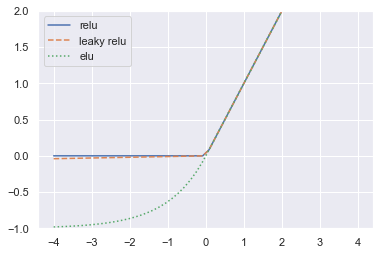

In [29]:
def leaky_relu(x):
    return tf.maximum(0.01 * x, x)

plt.plot(xx, tf.nn.relu(xx), label='relu')
plt.plot(xx, leaky_relu(xx), label='leaky relu', ls='--')
plt.plot(xx, tf.nn.elu(xx), label='elu', ls=':')
plt.legend(loc=2)
plt.ylim(-1, 2);

### Exercise: Exploring activation functions


Adjust the activation function in the XOR neural network.  What function gives the fastest training?  The highest accuracy?


## Initial weights


Sharp-eyed readers may have already noticed something done differently in the neural networks: the weights are initialized randomly, instead of being set to zero.  This breaks the symmetry of the two hidden neurons, so that they can evolve to detect different features.  All the weights being zero is a meta-stable state of the network, and gradient descent will not move it from that state.  A "proper" solution would be to set the weights to be orthogonal vectors, but in practice random weights are "orthogonal enough".

Usually the biases can be initialized to zero.  A small positive bias is sometimes used with the ReLU activation function, to push the system towards non-zero gradients.


### Exercise: Softmax network


Modify `DenseNeuralNetwork` to be suitable for the MNIST handwriting data set (i.e. for multi-class classification).  Adjust the size of that hidden layer and its activation function to optimize the performance of the network.

*Copyright &copy; 2019 Pragmatic Institute. This content is licensed solely for personal use. Redistribution or publication of this material is strictly prohibited.*